---

## Проектная работа. Аналитика в Яндекс.Афише

Цель работы: проанализировать бизнес-метрики и выдать рекомендации отделу маркетинга: 

    1) от каких источников трафика стоит отказаться;
    2) перераспределить бюджет.

Содержание: <a name="step9"></a>

[1. Загрузка данных и предобработка;](#step1)

[2. Анализ данных и расчет бизнес-метрик;](#step2)
   
   [2.1. Продуктовые метрики;](#step3)
   
   [2.2. Метрики электронной коммерции;](#step4) 
   
   [2.3. Маркетинговые метрики;](#step5)

[3. Общие выводы](#step6)

[3.1. Источники трафика и типы устройств, на которые стоит сделать упор отделу маркетинга;](#step7)
   
   [3.2. Общие выводы для каждого типа метрик: продуктовые, метрики электронной коммерции, маркетинговые;](#step8) 
   
   [3.3. Итоги когортного анализа;](#step9)

Описание данных:

Структура visits_log.csv

    Uid — уникальный идентификатор пользователя,
    Device — категория устройства пользователя,
    Start Ts — дата и время начала сессии,
    End Ts — дата и время окончания сессии,
    Source Id — идентификатор источника перехода на сайт.

Структура orders_log.csv

    Uid — уникальный идентификатор пользователя,
    Buy Ts — дата и время заказа,
    Revenue — сумма заказа.

Структура costs.csv

    source_id — идентификатор рекламного источника,
    dt — дата проведения рекламной кампании,
    costs — расходы на эту кампанию.

### 1. Загрузка данных и предобработка<a name="step1"></a> 

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')


In [2]:
# Загрузка данных
filepath1 = r'C:\Users\Torberg\Documents\Yandex Projects\Project6\visits_log.csv'
filepath2 = r'C:\Users\Torberg\Documents\Yandex Projects\Project6\orders_log.csv'
filepath3 = r'C:\Users\Torberg\Documents\Yandex Projects\Project6\costs.csv'

visits = pd.read_csv(filepath1)
orders = pd.read_csv(filepath2)
costs = pd.read_csv(filepath3)


In [3]:
# Создание функции для поиска пропусков
def nans_counter(column, data):
    print('Количество пропусков в столбце', column, ':', data[column].isna()
          .sum())


In [4]:
# Поиск пропусков и дубликатов в данных
# Датасет visits
for column in visits:
    nans_counter(column, visits)
print('Обнаруженное количество дубликатов:', visits.duplicated().sum())

# Датасет orders
print('*********************************************')
for column in orders:
    nans_counter(column, orders)
print('Обнаруженное количество дубликатов:', orders.duplicated().sum())

# Датасет costs
print('*********************************************')
for column in costs:
    nans_counter(column, costs)
print('Обнаруженное количество дубликатов:', costs.duplicated().sum())

Количество пропусков в столбце Device : 0
Количество пропусков в столбце End Ts : 0
Количество пропусков в столбце Source Id : 0
Количество пропусков в столбце Start Ts : 0
Количество пропусков в столбце Uid : 0
Обнаруженное количество дубликатов: 0
*********************************************
Количество пропусков в столбце Buy Ts : 0
Количество пропусков в столбце Revenue : 0
Количество пропусков в столбце Uid : 0
Обнаруженное количество дубликатов: 0
*********************************************
Количество пропусков в столбце source_id : 0
Количество пропусков в столбце dt : 0
Количество пропусков в столбце costs : 0
Обнаруженное количество дубликатов: 0


In [5]:
# Ознакомление с данными, переименование столбцов
visits.info()
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
display(visits.sample(5))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,device,end_ts,source_id,start_ts,uid
99733,desktop,2018-02-15 14:00:00,4,2018-02-15 13:52:00,14908129424161227129
269452,desktop,2018-05-18 11:16:00,1,2018-05-18 10:48:00,11954787923182424340
68984,desktop,2017-08-25 20:45:00,2,2017-08-25 18:41:00,11616947936617491261
223851,desktop,2017-09-18 09:23:00,4,2017-09-18 09:21:00,8885193572836172977
59632,desktop,2018-03-20 23:37:00,1,2018-03-20 22:53:00,14055337054927403241


In [6]:
# Ознакомление с данными, переименование столбцов
orders.info()
orders.columns = ['buy_ts', 'revenue', 'uid']
display(orders.sample(5))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,buy_ts,revenue,uid
18925,2017-11-23 08:19:00,12.22,15239488130214522285
36832,2018-02-25 10:51:00,0.61,9618722698407090234
26029,2017-12-25 21:13:00,11.00,5110705995628201478
22912,2017-12-08 22:06:00,4.28,11754424559582657748
36329,2018-02-22 11:05:00,6.72,1253289692437100599


In [7]:
# Ознакомление с данными, переименование столбцов
costs.info()
display(costs.sample(5))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
868,3,2017-10-21,195.93
2495,10,2018-04-15,10.28
1678,5,2018-01-13,107.32
2512,10,2018-05-02,3.50
2009,9,2017-12-11,25.71


In [8]:
# Выполним перевод данных о датах в формат datetime64
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [9]:
# Выполним перевод данных о датах в формат datetime64
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
orders.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [10]:
# Выполним перевод данных о датах в формат datetime64
costs['dt'] = pd.to_datetime(costs['dt'])
costs.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


#### Промежуточный вывод
Загружены данные с посещениями сайта сервиса, оплаченными заказами и расходами на рекламу. Пропусков и дубликатов в датасетах не обнаружено. Обнаруженные проблемы - во всех датафреймах данные с датами имеют тип object. В названиях столбцов найдены пробелы и заглавные буквы. Все недостатки устранены.

[Наверх](#step9)

### 2. Анализ полученных данных<a name="step2"></a> 

### 2.1 Продуктовые метрики<a name="step3"></a> 

In [11]:
# Добавление новых столбцов для подсчета метрик DAU, WAU, MAU
visits['session_year'] = visits['start_ts'].astype('datetime64[Y]')
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['session_week'] = visits['start_ts'].astype('datetime64[W]')
visits['session_date'] = visits['start_ts'].astype('datetime64[D]')
# Создание срезов датафрема visits по типу используемого устройства
visits_desktop = visits[visits['device'] == 'desktop']
visits_touch = visits[visits['device'] == 'touch']


In [12]:
# Создание функции, словаря и списка для построения графиков
diction = {1: 'Значение метрики', 2: 'День', 3: 'Неделя', 4: 'Месяц'}
titles_list = ['Изменение DAU во времени',
               'Изменение WAU во времени',
               'Изменение MAU во времени',
               'Изменение ежедневного количества посещений сервиса']


def bar_func(column1, column2, data1, data2, title, x, y):
    plt.figure(figsize=(24, 18))
    plt.bar(data1[column1], data1[column2], label='desktop')
    plt.bar(data2[column1], data2[column2], label='touch')
    plt.title(title, fontsize=20)
    plt.xlabel(x, fontsize=16)
    plt.ylabel(y, fontsize=16)
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.show()


In [13]:
# Расчет метрики DAU (daily active users) в разрезе типа устройств
dau = visits.groupby(['device', 'session_date']).agg({'uid': 'nunique'}).\
    reset_index()
dau_mean = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()
dau_desktop = visits_desktop.groupby('session_date').agg({'uid': 'nunique'}).\
    reset_index()
dau_touch = visits_touch.groupby('session_date').agg({'uid': 'nunique'}).\
    reset_index()
dau_desktop_mean = visits_desktop.groupby('session_date').agg({'uid': 
                                                               'nunique'}).mean()
dau_touch_mean = visits_touch.groupby('session_date').agg({'uid': 'nunique'}).\
    mean()
print('Среднее количество уникальных пользователей в день с desktop-устройств:\
    ', int(dau_desktop_mean))
print('Среднее количество уникальных пользователей в день с touch-устройств:\
    ', int(dau_touch_mean))


Среднее количество уникальных пользователей в день с desktop-устройств:     659
Среднее количество уникальных пользователей в день с touch-устройств:     252


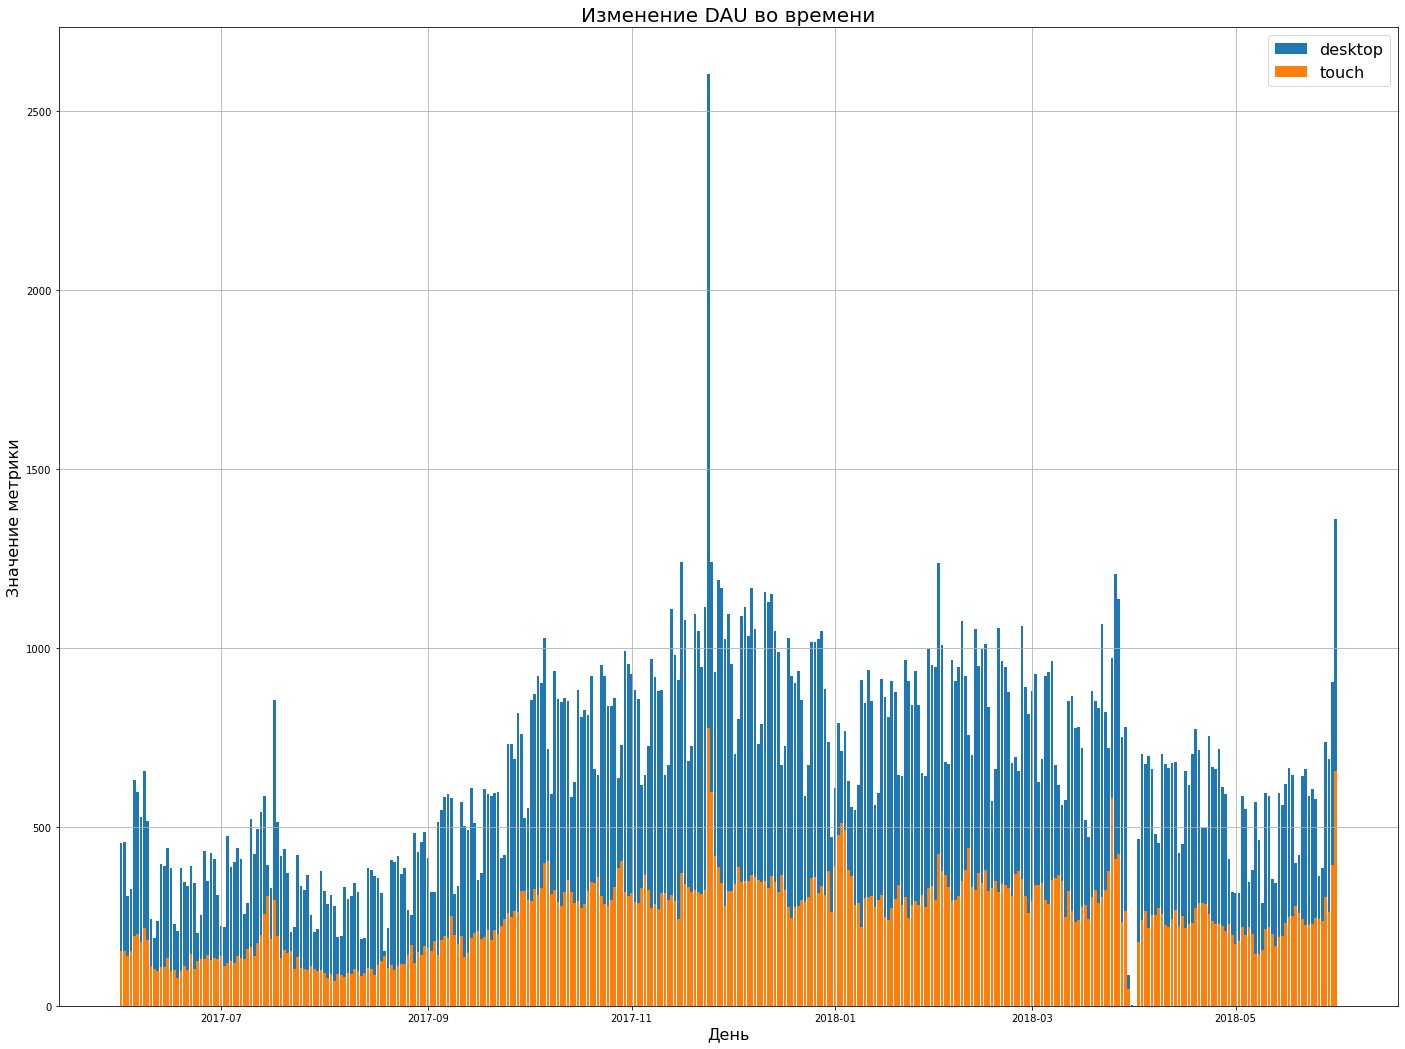

In [14]:
# Изменение DAU во времени
bar_func('session_date', 'uid', dau_desktop, dau_touch, titles_list[0],
         diction[2], diction[1])

In [15]:
# Расчет метрики WAU в разрезе типа устройств
wau_desktop = visits_desktop.groupby('session_week').agg({'uid': '\
nunique'}).reset_index()
wau_touch = visits_touch.groupby('session_week').agg({'uid': '\
nunique'}).reset_index()
wau_desktop_mean = visits_desktop.groupby('session_week').agg({'uid\
': 'nunique'}).mean()
wau_touch_mean = visits_touch.groupby('session_week').agg({'uid': '\
nunique'}).mean()
print('Среднее количество уникальных пользователей в неделю с desktop\
-устройств:', int(wau_desktop_mean))
print('Среднее количество уникальных пользователей в неделю с touch-устройств:\
', int(wau_touch_mean))

Среднее количество уникальных пользователей в неделю с desktop-устройств: 4135
Среднее количество уникальных пользователей в неделю с touch-устройств: 1637


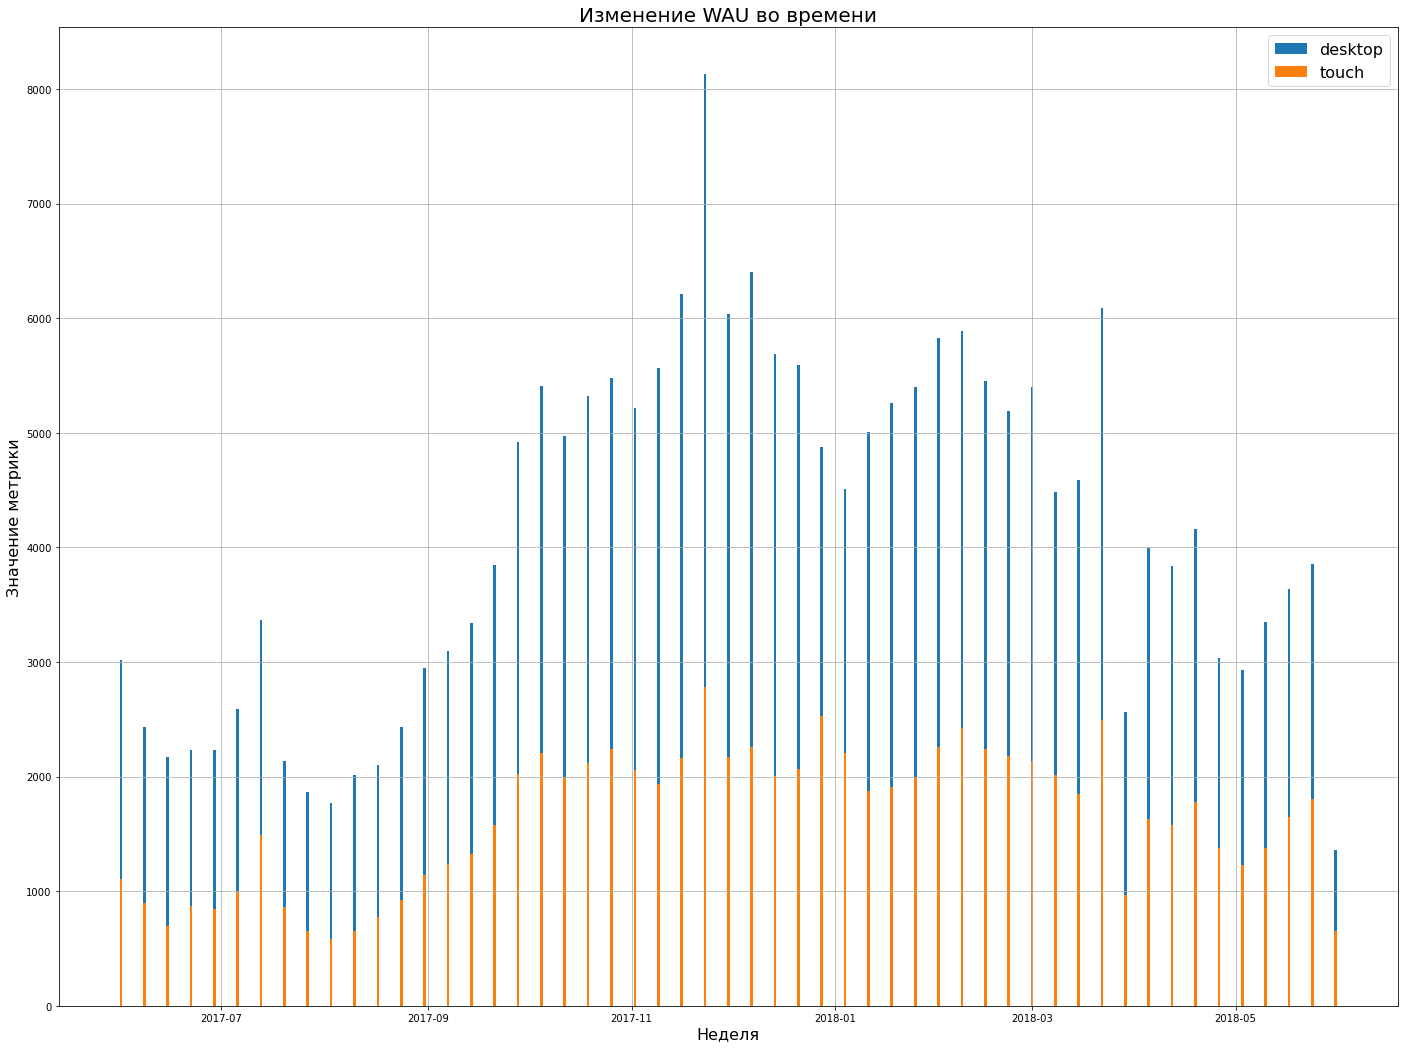

In [16]:
# Изменение WAU во времени
bar_func('session_week', 'uid', wau_desktop, wau_touch, titles_list[1], 
         diction[3], diction[1])

In [17]:
# Расчет метрики MAU
mau_desktop = visits_desktop.groupby('session_month').agg({'uid': 'nunique'})\
    .reset_index()
mau_touch = visits_touch.groupby('session_month').agg({'uid': 'nunique'})\
    .reset_index()
mau_desktop_mean = visits_desktop.groupby('session_month')\
    .agg({'uid': 'nunique'}).mean()
mau_touch_mean = visits_touch.groupby('session_month')\
    .agg({'uid': 'nunique'}).mean()
print('Среднее количество уникальных пользователей в месяц с \
desktop-устройств:', int(mau_desktop_mean))
print('Среднее количество уникальных пользователей в месяц с \
touch-устройств:', int(mau_touch_mean))

Среднее количество уникальных пользователей в месяц с desktop-устройств: 16724
Среднее количество уникальных пользователей в месяц с touch-устройств: 6825


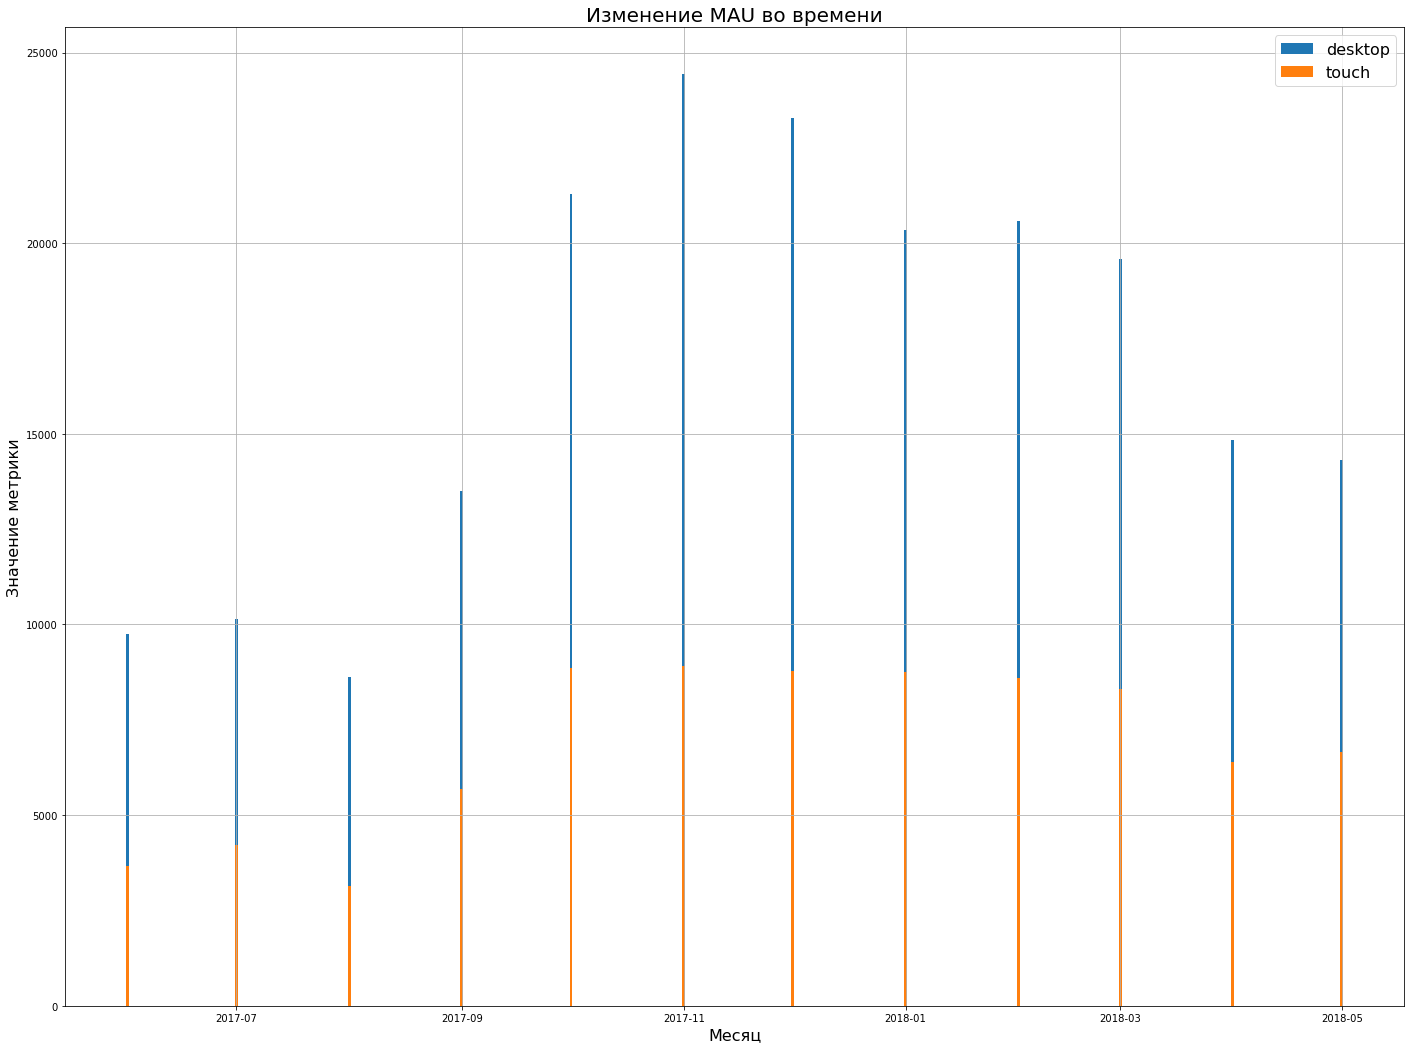

In [18]:
# Изменение MAU во времени
bar_func('session_month', 'uid', mau_desktop, mau_touch, titles_list[2],
         diction[4], diction[1])

### Промежуточный вывод
Подсчет метрик активности пользователей позволяет сделать вывод, что пользователи активнее пользуются сервисом с помощью desktop-устройств. Это сигнал о том, что стоит проанализировать мобильную версию сайта или приложение, возможно у пользователей возникают сложности с использованием touch-версии сервиса.

Изменение этих метрик во времени подсказывает нам о том, что в летнее время активность пользователей снижается. Это может быть связано с тем, что наступает пора отпусков. Пользователи отдыхают, да и артисты тоже :)) 

In [19]:
# Подсчет среднего количества посещений в день
mean_visits_per_day = visits.groupby('session_date')\
    .agg({'uid': 'count'}).mean()
print('Среднее количество посещений сервиса в день:', int(mean_visits_per_day))
print('Разность между средним количеством посещений в день и метрикой DAU:',
      int(mean_visits_per_day) - int(dau_mean))
visits_per_day_desktop = visits_desktop.groupby('session_date')\
                         .agg({'uid': 'count'}).reset_index()
visits_per_day_touch = visits_touch.groupby('session_date')\
                         .agg({'uid': 'count'}).reset_index()


Среднее количество посещений сервиса в день: 987
Разность между средним количеством посещений в день и метрикой DAU: 80


Около 80 пользователей (около 8%) в день заходят на сайт повторно - либо что-то докупают, либо промониторив другие сервисы все-таки возвращаются к Афише. Это хорошая тенеденция, но будет еще лучше, если этот показатель поднимется до 15 %. Это причина провести более детальное исследование.

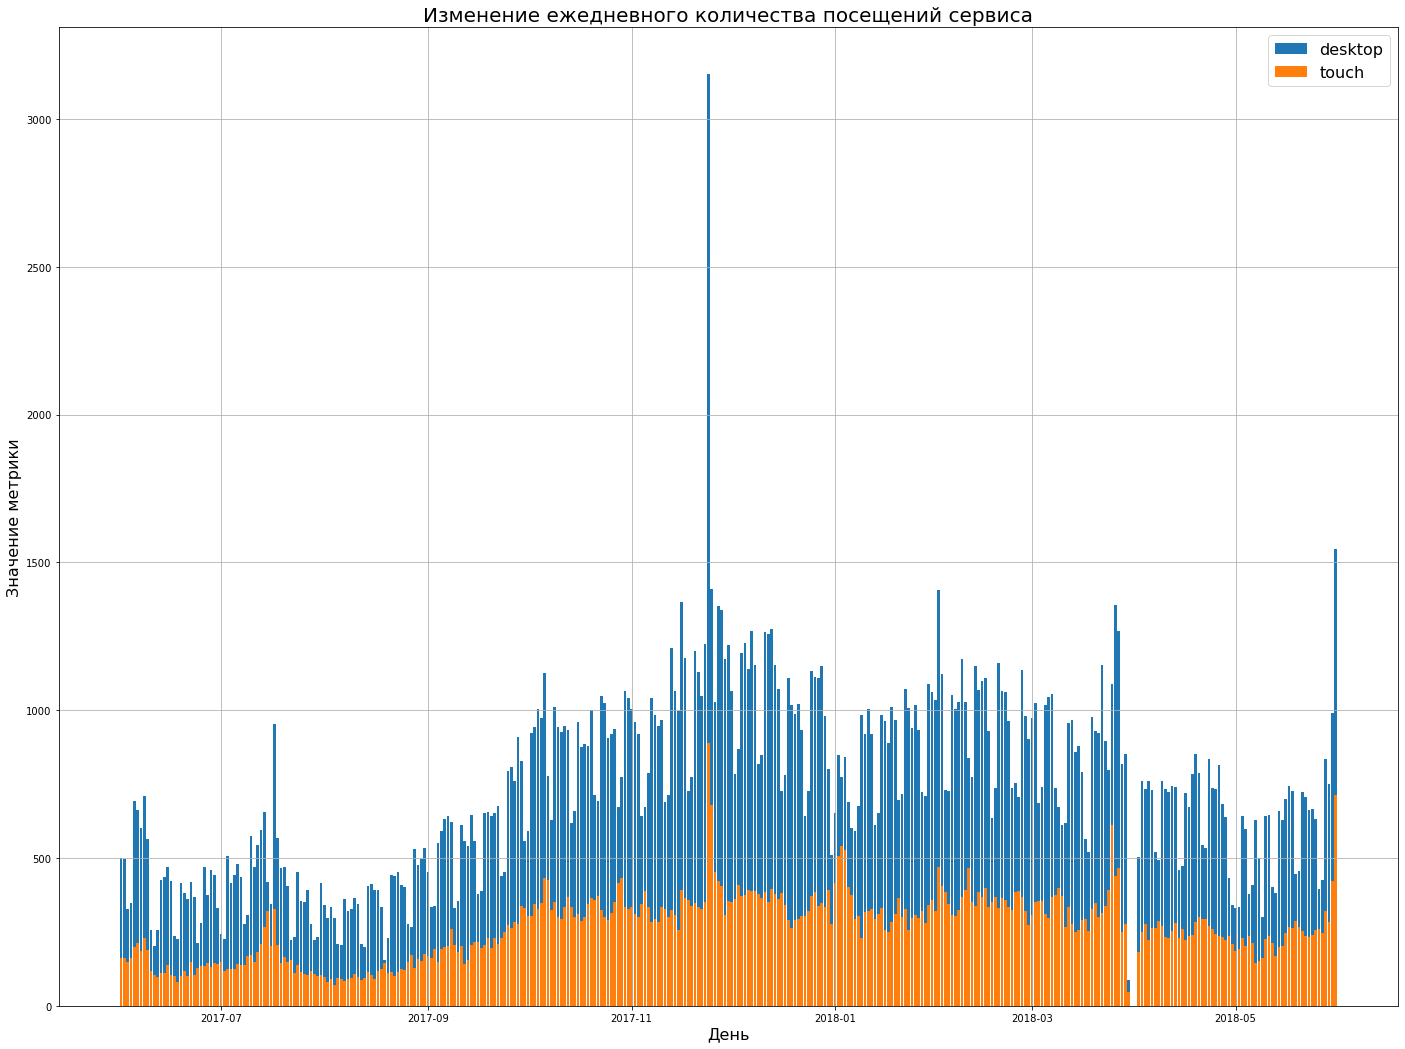

In [20]:
# Изменение ежедневного количества посещений сервиса
bar_func('session_date', 'uid', visits_per_day_desktop, visits_per_day_touch,
         titles_list[3], diction[2], diction[1])

### Промежуточный вывод
Метрика "Изменение ежедневного количества посещений сервиса" повторяет поведение метрики DAU и для нее можно сделать схожие выводы: desktop-устройства пользуются большей популярностью, летом популярность сервиса снижается.

In [21]:
# Подсчет средней продолжительности сессии
visits_desktop['session_duration'] = (visits['end_ts'] - visits['start_ts'])\
                                      .dt.seconds
visits_touch['session_duration'] = (visits['end_ts'] - visits['start_ts'])\
                                    .dt.seconds

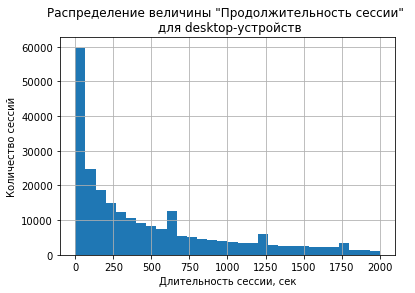

In [22]:
# Построение гистограммы для оценки типа распределения величины
(visits_desktop['session_duration']).hist(bins=30, range=(0, 2000))
plt.title('Распределение величины "Продолжительность сессии" \n для desktop-устройств')
plt.xlabel('Длительность сессии, сек')
plt.ylabel('Количество сессий')
plt.show()


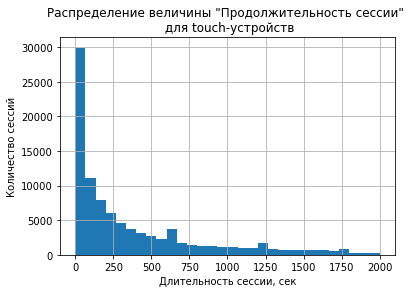

In [23]:
# Построение гистограммы для оценки типа распределения величины
(visits_touch['session_duration']).hist(bins=30, range=(0, 2000))
plt.title('Распределение величины "Продолжительность сессии" \n для touch-устройств')
plt.xlabel('Длительность сессии, сек')
plt.ylabel('Количество сессий')
plt.show()


Распределение случайной величины "длительность сессии пользователя" не является нормальным, поэтому в качестве средней продолжительности сессии выбрана мода - наиболее часто встречающееся значение

In [24]:
# Средняя продолжительность сессии
asl_desktop = visits_desktop['session_duration'].mode()
asl_touch = visits_touch['session_duration'].mode()
print(asl_desktop)
print(asl_touch)

0    60
dtype: int64
0    60
dtype: int64


### Промежуточный вывод
Средняя продолжительность сессии пользователя составляет 1 минуту, что говорит об удобстве сервиса (по крайней мере пользователи не закрывают сайт сразу же, а задерживаются на нём - сделать заказ). Для продолжительности сессии больше 1 минуты можно предположить, что пользователи ознакамливаются с предстоящими событиями.

In [25]:
# Создание функции, словаря и списка для построения необходимой визуализации
titles_list2 = ['Изменение Retention Rate по месячным когортам пользователей',
                'Изменение LTV по месячным когортам пользователей',
                'Изменение ROMI по месячным когортам пользователей',
                'Изменение ROMI по месячным когортам пользователей в разрезе\
 источников',
                'Изменение среднего числа покупок на 1 пользователя по\
 когортам']
diction2 = {1: 'Возраст когорты',
            2: 'Источник трафика',
            3: 'Первый месяц заказа',
            4: 'Первый месяц посещения сервиса'}


# Создание функции для построения необходимой визуализации
def heatmap_func(data, fmt, title, x, y, vmin, vmax, yrotation):
    plt.figure(figsize=(24, 18))
    sns.heatmap(data, annot=True, annot_kws ={'fontsize': 16},
                fmt=fmt, linewidths=1, linecolor='white',
                vmin=vmin, vmax=vmax)
    plt.tick_params(axis='x', which='major', labelsize=14)
    plt.tick_params(axis='y', which='major', labelsize=14, labelrotation=yrotation)
    plt.title(title, fontsize=20)
    plt.xlabel(x, fontsize=16)
    plt.ylabel(y, fontsize=16)
    plt.show()


In [26]:
# Поиск retention rate
# выделение месячной когорты пользователей
first_visit_date = visits.groupby('uid')['start_ts'].min()
first_visit_date.name = 'first_visit_date'
visits = visits.join(first_visit_date, on='uid')
visits['visit_month'] = visits['start_ts'].astype('datetime64[M]')
visits['first_visit_month'] = visits['first_visit_date']\
.astype('datetime64[M]')
display(visits.sample(5))

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,first_visit_date,visit_month,first_visit_month
317275,desktop,2017-11-23 13:26:00,4,2017-11-23 13:25:00,15990347497742198201,2017-01-01,2017-11-01,2017-11-23,2017-11-23,2017-09-14 12:17:00,2017-11-01,2017-09-01
13357,desktop,2017-11-25 11:26:00,5,2017-11-25 11:08:00,10215533847743830836,2017-01-01,2017-11-01,2017-11-23,2017-11-25,2017-11-25 11:08:00,2017-11-01,2017-11-01
13594,desktop,2018-03-15 12:15:00,2,2018-03-15 12:12:00,18281785365782433119,2018-01-01,2018-03-01,2018-03-15,2018-03-15,2018-03-15 12:12:00,2018-03-01,2018-03-01
356728,touch,2018-01-16 21:39:00,3,2018-01-16 21:25:00,1195661289183329302,2018-01-01,2018-01-01,2018-01-11,2018-01-16,2018-01-16 21:25:00,2018-01-01,2018-01-01
70964,desktop,2018-01-29 16:20:00,9,2018-01-29 16:08:00,16215029968738369653,2018-01-01,2018-01-01,2018-01-25,2018-01-29,2017-10-26 10:00:00,2018-01-01,2017-10-01


In [27]:
# Добавление в таблицу возраста когорты
visits['cohort_lifetime'] = (visits['visit_month'] -
                             visits['first_visit_month'])/\
np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')
display(visits.sample(5))

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,first_visit_date,visit_month,first_visit_month,cohort_lifetime
53376,desktop,2018-05-29 14:09:00,3,2018-05-29 13:33:00,3487074208559078178,2018-01-01,2018-05-01,2018-05-24,2018-05-29,2018-05-28 11:17:00,2018-05-01,2018-05-01,0
235720,desktop,2017-07-04 21:13:00,2,2017-07-04 21:13:00,14178999147297285358,2017-01-01,2017-07-01,2017-06-29,2017-07-04,2017-07-04 21:13:00,2017-07-01,2017-07-01,0
211460,desktop,2017-12-04 12:57:00,5,2017-12-04 12:57:00,1800733069998918397,2017-01-01,2017-12-01,2017-11-30,2017-12-04,2017-12-01 12:18:00,2017-12-01,2017-12-01,0
179975,desktop,2018-01-08 22:52:00,5,2018-01-08 22:52:00,17669852828781287391,2018-01-01,2018-01-01,2018-01-04,2018-01-08,2018-01-08 22:52:00,2018-01-01,2018-01-01,0
133845,desktop,2017-06-15 14:27:00,3,2017-06-15 14:24:00,8466505977026438861,2017-01-01,2017-06-01,2017-06-15,2017-06-15,2017-06-15 14:24:00,2017-06-01,2017-06-01,0


cohort_lifetime
0     1.000000
1     0.065182
2     0.046200
3     0.042778
4     0.040500
5     0.039286
6     0.036833
7     0.037400
8     0.035500
9     0.035333
10    0.034000
11    0.045000
Name: retention, dtype: float64

AttributeError: Can only use .dt accessor with datetimelike values

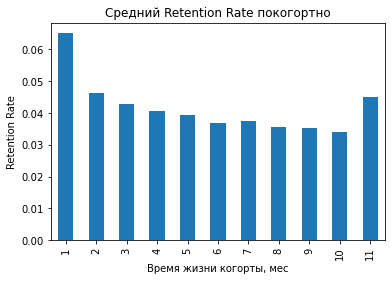

In [28]:
# Расчет Retention Rate
cohorts = visits.groupby(['first_visit_month', 'cohort_lifetime'])\
                        .agg({'uid': 'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0]\
[['first_visit_month', 'uid']]
initial_users_count = initial_users_count.\
    rename(columns={'uid': 'cohort_users'})
cohorts = cohorts.merge(initial_users_count, on='first_visit_month')
cohorts['retention'] = (cohorts['uid'] / cohorts['cohort_users']).round(3)
retention_pivot = cohorts.pivot_table(index='first_visit_month',
                                      columns='cohort_lifetime',
                                      values='retention',
                                      aggfunc='sum')
#display(retention_pivot.fillna(''))
# Поиск среднего Retention Rate для когорт с возрастом 6 месяцев и более
#cohorts_m6 = cohorts[cohorts['cohort_lifetime'] >= 6]
mean_retention = cohorts.groupby('cohort_lifetime')['retention'].mean()

display(mean_retention)
mean_retention.drop(mean_retention.index[0]).plot.bar()
plt.ylabel('Retention Rate')
plt.title('Средний Retention Rate покогортно')
plt.xlabel('Время жизни когорты, мес')
mean_retention.name = 'mean_retention_rate'
retention_pivot = retention_pivot.append(mean_retention.round(3))                                                       

formatted_dates = list(retention_pivot.index.to_series()[:-1].dt.strftime('%Y-%m'))
retention_pivot.index = formatted_dates + ['Mean_Retention']
display(retention_pivot.fillna(''))

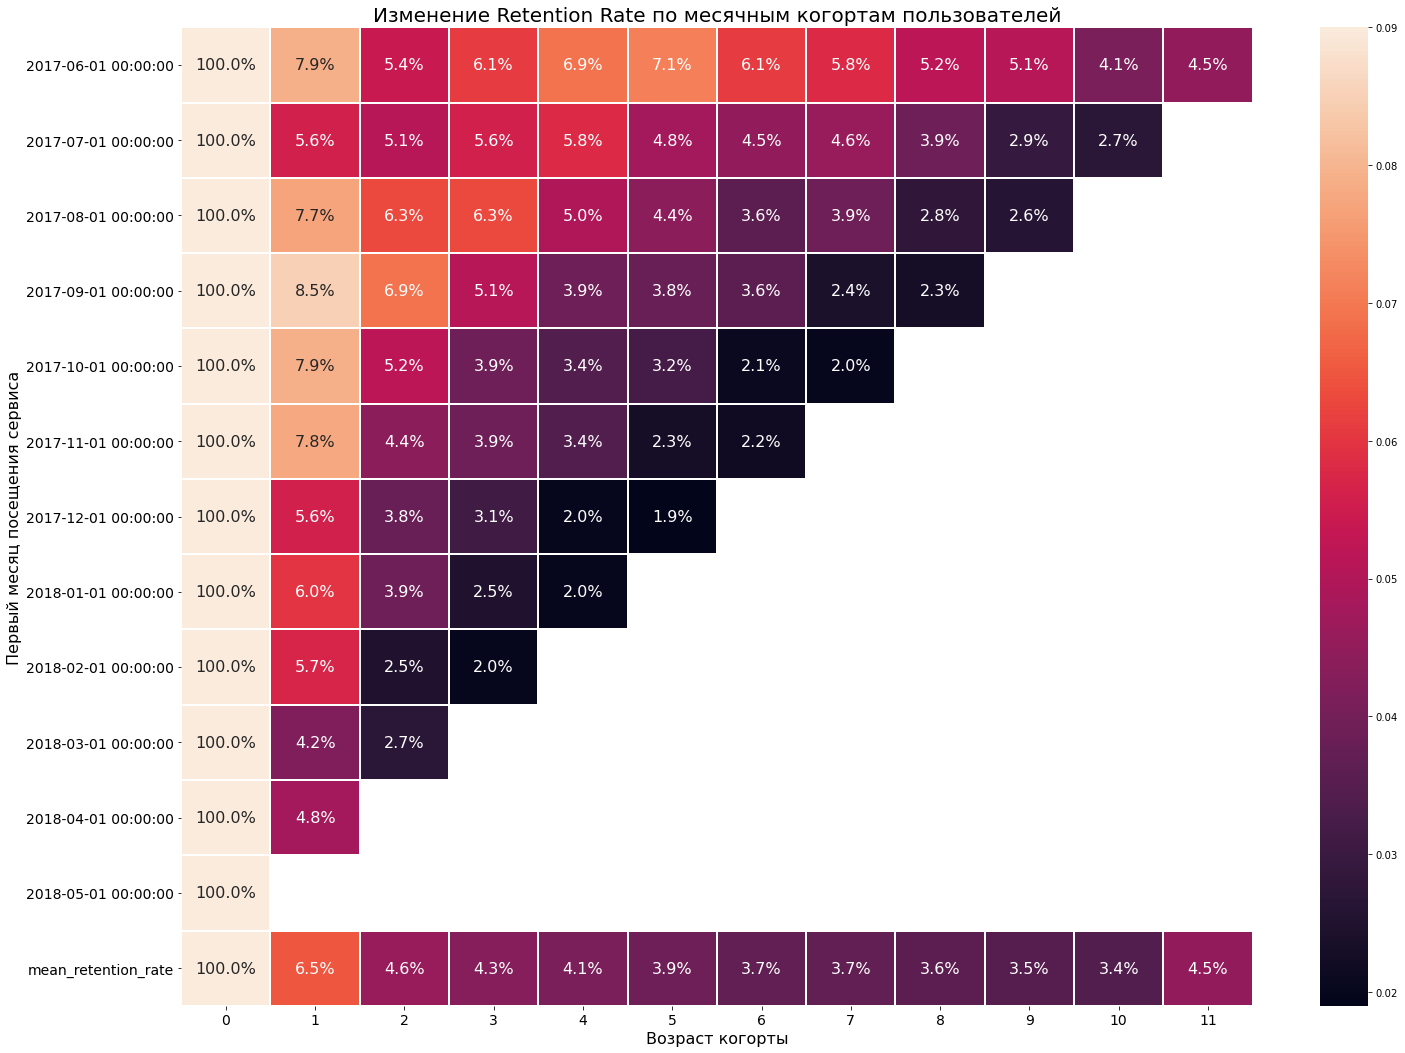

In [29]:
# Визуализация значений Retention Rate, найденного методом когортного анализа
heatmap_func(retention_pivot, '.1%', titles_list2[0], diction2[1], diction2[4], None, 0.09, 0.0)


### Промежуточный вывод

Посчитана метрика Retention Rate с помощью когортного анализа. Поскольку исследуемый период равен 1 году, в качаестве исследуемых выбраны месячные когорты. По построенным графикам видно, что Retention Rate колеблется в районе 2-8%, а средний равен около 4%. Самой перспективной является когорта 06-2017 - её retention rate составляет 4,5 %. 

### Вывод по продуктовым метрикам
В качестве продуктовых посчитаны следующие метрики: ежедневная/еженедельная/ежемесячная активность пользователей - DAU, WAU, MAU; средняя продолжительность сессии пользователя - asl; коэффициент удержания пользователей - Retention Rate. По значениям этих метрик и их изменения во времени можно сделать следующие выводы:

1) пользователи более предпочитают использовать desktop-устройства для посещения сервиса, что может послужить сигналом для разраюотчиков - стоит проанализировать мобильную версию, возможно у нее есть недостатки или неудобства, которые отталкивают потенциальных покупателей;

2) значение средней продолжительности сессии равняется одной минуте, что может свидетельствовать об удобстве сервиса - "зашел, увидел, приобрел" :) Либо пользователь знакомится с предстоящими событиями, если время сессии составляет более 1 минуты;

3) средний Retention Rate для когорт пользователей с временем жизни более полугода находится на уровне 3,5 - 4,5%. Отделу маркетинга стоит поднапрячься, чтобы повысить этот показатель, ведь повторные покупки не менее важны чем единичные. Плюс, если перелопатить мобильную версию сайта (привет разработчикам), то Retention Rate также может подрасти.

[Наверх](#step9)

### 2.2 Метрики электронной коммерции<a name="step4"></a> 

,uid,first_visit_date,buy_ts,revenue
757003,13444960617174387228,2017-11-09 11:44:00,2017-11-09 11:47:00,0.61
685339,15164890204173880373,2018-02-15 13:21:00,2018-02-16 10:01:00,7.00
707928,8371936749338077472,2017-12-17 20:14:00,2018-05-28 23:29:00,0.70
688468,9432508079141257817,2017-07-28 12:30:00,2018-05-31 11:25:00,0.92
740630,62487689894318901,2017-12-05 20:47:00,2017-12-05 20:51:00,4.58


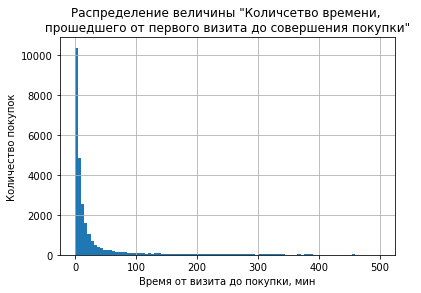

In [30]:
# Поиск количества времени, прошедшего от первого визита до совершения покупки
visits_query = visits[['uid', 'first_visit_date']]
first_buy_date = pd.merge(visits_query, orders, on='uid')

first_buy_date = first_buy_date.drop_duplicates()
#first_buy_date.info()
display(first_buy_date.sample(5))
first_buy_date['first_buy_time'] = (first_buy_date['buy_ts'] -
                                    first_buy_date['first_visit_date']) /\
                                    np.timedelta64(1, 'm')

first_buy_date['first_buy_time'].hist(bins=100, range=(0, 500))
plt.title('Распределение величины "Количсетво времени, \n прошедшего от первого визита до совершения покупки" ')
plt.xlabel('Время от визита до покупки, мин')
plt.ylabel('Количество покупок')
plt.show()

Здесь так же для поиска необходимой метрики воспользуемся модой, поскольку распределение не является нормальным.

In [31]:
print('Среднее количество времени, прошедшее от первого визита до покупки:',
      first_buy_date['first_buy_time'].mode())
      

Среднее количество времени, прошедшее от первого визита до покупки: 0    1.0
dtype: float64


### Промежуточный вывод
Среднее время от первого визита до совершения покупки равно средней длине сессии и составляет 1 минуту, что может сигнализировать об успешной работе маркетологов - пользователь посещает сайт с намерением приобрести товар/услугу.

In [ ]:
# Добавляем дополнительные столбцы к датафрейму с заказами
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']


In [ ]:
# Среднее число покупок на 1 пользователя за 6 месяцев
mean_buys_per_user = orders.merge(first_orders, on='uid')
mean_buys_per_user['cohort_lifetime'] = (mean_buys_per_user['order_month'] -
                                         mean_buys_per_user
                                         ['first_order_month']) /\
                                         np.timedelta64(1, 'M')
mean_buys_per_user['cohort_lifetime'] = mean_buys_per_user['cohort_lifetime']\
    .round().astype('int')

buys_count = mean_buys_per_user.groupby(['order_month', 'uid'])\
    .agg({'revenue': 'count'}).reset_index()
buys_count.columns = ['order_month', 'uid', 'buys_count']

mean_buys_per_user = mean_buys_per_user.merge(buys_count,
                                              on=['order_month', 'uid'])
display(mean_buys_per_user.sample(5))

buys_per_user_report = mean_buys_per_user\
    .pivot_table(index='first_order_month',
                 columns='cohort_lifetime',
                 values='buys_count',
                 aggfunc='mean')

#buys_cohort = mean_buys_per_user[mean_buys_per_user['cohort_lifetime'] >= 6]
mean_buys_count = mean_buys_per_user.groupby('cohort_lifetime')['buys_count']\
    .mean().round(2)
mean_buys_count.name = 'mean_buys_count'
buys_per_user_report = buys_per_user_report.append(mean_buys_count)
formatted_dates_buys = list(buys_per_user_report.index.to_series()[:-1].dt.strftime('%Y-%m'))
buys_per_user_report.index = formatted_dates_buys + ['mean_buys_count']
display(buys_per_user_report.round(1).fillna(''))

In [ ]:
heatmap_func(buys_per_user_report, '.1f', titles_list2[4], diction2[1], diction2[3], None, None, 0.0)

### Промежуточный вывод
С помощью когортного анализа посчитана метрика "Среднее число покупок на 1 пользователя за 6 месяцев". Самой перспективной снова видится самая "долгоживущая" когорта - 06-2017. К 11 месяцу своей "жизни" количество средних покупок может насторожить, однако мы снова выходим на летнее время года, когда активность пользователей сервисом Афиша снижается, поэтому не стоит паниковать - в активное время года (возраст когорты 2-8 на графике) активность пользователей на высоком уровне (16-19 покупок в месяц). 

In [ ]:
# Подсчет средней выручки с пользователя
mean_revenue_by_user = orders.groupby('order_month').agg({'uid': 'nunique',
                                                          'revenue': 'sum'})\
                                                          .reset_index()
mean_revenue_by_user.columns = ['buy_month', 'users_count', 'sum_revenue']
mean_revenue_by_user['mean_revenue'] = (mean_revenue_by_user['sum_revenue'] /
                                        mean_revenue_by_user['users_count'])\
                                        .round(2)
display(mean_revenue_by_user)


In [ ]:
# Изменение средней выручки с пользователя с течением времени
plt.figure(figsize=(20, 15))
plt.bar(mean_revenue_by_user['buy_month'],
        mean_revenue_by_user['mean_revenue'])
plt.title('Изменение средней выручки с пользователя с течением времени',
          fontsize=20)
plt.xlabel('Месяц', fontsize=16)
plt.ylabel('Средняя выручка с пользователя, у.е.', fontsize=16)
plt.show()


### Промежуточный вывод
На графике "Изменение средней выручки с пользователя с течением времени" можно отметить, что наибольшую выручку сервис Афиша может получить в сентябре(дорвались после отпуска =) ), декабре (холодно, лучше сходить в театр, чем на каток) и марте (подарок "второй половинке" - посещение интересного мероприятия). А в летние месяцы можно просто погулять (июнь) или посетить мероприятия на открытом воздухе (июль-август). К тому же рискну предположить: по метрикам DAU,WAU,MAU активность пользователей летом снижается, поэтому освобождаются более удобные места (поближе к сцене мероприятия или VIP-места), оттого и увеличивается средняя выручка с пользователя.

In [ ]:
# Расчет LTV
# Ищем новых пользователей по месяцам
cohort_sizes = first_orders.groupby('first_order_month')\
    .agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

# Строим месячные когорты
new_orders = orders.merge(first_orders, on='uid')

cohorts = new_orders.groupby(['first_order_month', 'order_month'])\
    .agg({'revenue': 'sum'}).reset_index()


report = pd.merge(cohort_sizes, cohorts, on='first_order_month')


# Поскольку маржинальность сервиса равна 100% для расчета ltv берем столбец
# revenue
margin_rate = 1.0
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) /\
                 np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['gp'] / report['n_buyers']

ltv_pivot = report.pivot_table(index='first_order_month',
                               columns='age',
                               values='ltv',
                               aggfunc='mean')

ltv_pivot = ltv_pivot.cumsum(axis=1).round(2)

mean_ltv = ltv_pivot.mean(axis=0)
mean_ltv.name = 'mean_ltv'
display(mean_ltv)
ltv_pivot = ltv_pivot.append(mean_ltv).round(2)
formatted_dates_ltv = list(ltv_pivot.index.to_series()[:-1].dt.strftime('%Y-%m'))
ltv_pivot.index = formatted_dates_ltv + ['mean_ltv']
display(ltv_pivot.fillna(''))


In [ ]:
# Построим визуализацию
heatmap_func(ltv_pivot, '.2f', titles_list2[1], diction2[1], diction2[3], None, None, 0.0)


### Промежуточный вывод
Посчитана метрика "LTV" с помощью когортного анализа. Самыми перспективными когортами являются пользователи, зарегистрировавшиеся в июне 2017 и сентябре 2017 (высокий показатель Ltv, который продолжает расти со временем). К тому же стоит присмотреться к когортам июля и августа 2017-го (метрика LTV приближается к 10 с течением времени).

### Общий вывод по метрикам электронной коммерции
В качестве метрик электронной коммерции посчитаны следующие: среднее время от первого визита до покупки, среднее количество покупок на 1 пользователя за 6 месяцев методом когортного анализа, средняя выручка с пользователя, LTV методом когортного анализа. По значению этих метрик и проведенного когортного анализа можно сделать следующие выводы:

1) среднее время от первого визита пользователя до покупки составляет 1 минуту - это успех маркетингового отдела сервиса;

2) метрика "среднее количество покупок на 1 пользователя" помогает установить самую перспективную когорту - пользователи, зарегистрировавшиеся в июне 2017 года. Рассмотрев дополнительно метрику "средняя выручка с 1 пользователя помесячно" подтверждаем вывод о том, что в летнее время года активность пользователей снижается, а осенью и зимой повышается;

3) по метрике LTV по месячным когортам пользователей можем выделить так же в "перспективные" когорты пользователей, зарегистрировавшихся в июле, августе и сентябре 2017 года.

[Наверх](#step9)

### 2.3 Маркетинговые метрики<a name="step5"></a> 

In [ ]:
# Подсчет общих трат на маркетинг, их распределение по типам устройств и во
# времени
sum_marketing = costs['costs'].sum()
source_marketing = costs.groupby('source_id')['costs'].sum().reset_index()

costs['month'] = costs['dt'].astype('datetime64[M]')
monthly_marketing = costs.groupby('month')['costs'].sum().reset_index()
display(sum_marketing)
display('***********************')
display(source_marketing)
display('***********************')
display(monthly_marketing)


In [ ]:
# Визуализация распределения затрат на маркетинг по источникам трафика
source_marketing['source_id'] = source_marketing['source_id'].astype('str')
plt.figure(figsize=(20, 15))
plt.bar(source_marketing['source_id'], source_marketing['costs'])
plt.title('Затраты на маркетинг в зависимости от источника трафика',
          fontsize=20)
plt.xticks(ticks = source_marketing['source_id'])
plt.xlabel('Источник трафика', fontsize=16)
plt.ylabel('Затраты, у.е.', fontsize=16)
plt.xlim(-1, len(source_marketing))
for i in range(len(source_marketing)):
    plt.text(i, i+source_marketing['costs'][i]+3000, source_marketing['costs'][i].round(2),
             horizontalalignment = 'center', fontsize = 16)

plt.show()


### Промежуточный вывод
На графике "Затраты на маркетинг в зависимости от источника трафика" можно выделить яркого лидера - источник №3. Источники 2, 4, 5 тоже обходятся компании в "кругленькую" сумму - от 40 до 60 тыс. у.е. Однако не торопимся урезать рекламный бюджет, необходимо подсчитать метрику ROMI, возможно затраты себя оправдают.

In [ ]:
# Визуализация распределения затрат на маркетинг во времени
plt.figure(figsize=(20, 15))
plt.bar(monthly_marketing['month'], monthly_marketing['costs'], width = 10)
plt.title('Ежемесячные затраты на маркетинг', fontsize=20)
plt.xlabel('Месяц', fontsize=16)
plt.ylabel('Затраты, у.е.', fontsize=16)
for i in range(len(monthly_marketing)):
    plt.text(monthly_marketing['month'][i],
             monthly_marketing['costs'][i]+500,
             monthly_marketing['costs'][i].round(2),
             horizontalalignment = 'center',
             fontsize = 16)
plt.show()


### Промежуточный вывод
График "Ежемесячные затраты на маркетинг" подтверждает сделанное предположение об активности пользователей в разрезе сезонности. Летом активность пользователей ниже, зимой выше, соответственно и затраты на рекламу меняются так же.

In [ ]:
# Подсчет CAC и ROMI методом когортного анализа
# Посчитаем траты на маркетинг помесячно
monthly_costs = costs.groupby('month')['costs'].sum()
# Составим новую таблицу для подсчета САС и ROMI
new_report = pd.merge(report, monthly_costs, left_on='first_order_month',
                      right_on='month')
new_report['cac'] = new_report['costs'] / new_report['n_buyers']
new_report['romi'] = new_report['ltv'] / new_report['cac']
display(new_report)


In [ ]:
# Подсчет CAC
cohort_cac = new_report.groupby('age')['cac'].mean().reset_index()
#display(cohort_cac.round(2))
cohort_cac['cac'].plot.bar()
plt.xlabel('Возраст когорты, мес')
plt.ylabel('Значение CAC')
plt.title('Метрика САС покогортно')
plt.ylim(0, cohort_cac['cac'].max()+2)
for i in range(len(cohort_cac)):
    plt.text(i, cohort_cac['cac'][i]+0.2, cohort_cac['cac'][i].round(2),
             horizontalalignment = 'center', rotation = 90)
plt.show()

In [ ]:
# Подсчет ROMI
output = new_report.pivot_table(index='first_order_month',
                                columns='age',
                                values='romi',
                                aggfunc='mean')
output = output.cumsum(axis=1).round(2)

#display(output.fillna(''))
mean_romi = output.mean(axis=0).round(2)
mean_romi.name = 'mean_romi'

output = output.append(mean_romi)
formatted_dates_romi = list(output.index.to_series()[:-1].dt.strftime('%Y-%m'))
output.index = formatted_dates_romi + ['mean_romi']
display(output.fillna(''))

In [ ]:
# Визуализация полученных данных
heatmap_func(output, '.0%', titles_list2[2], diction2[1], diction2[4], 0.4, None, 0.0)


### Промежуточный вывод
Подсчет метрики ROMI позволяет выделить в перспективные когорты следующие когорты впервые зарегистрировавшихся пользователей: июнь-2017, сентябрь-2017. Стоит присмотреться к следующим когортам - июль-2017, август-2017, декабрь-2017: накопительный ROMI для этих когорт стремится к 1.00.

In [ ]:
# Подсчет САС и ROMI в разрезе источников
# Поработаем с visits для поиска первых source_id  для каждого посетителя
visits_uniq = visits.groupby('uid').agg({'source_id': 'first',
                                         'start_ts': 'min'})
visits_uniq['first_visit_month'] = visits_uniq['start_ts']\
    .astype('datetime64[M]')

# Объединим visits и orders
source_orders = orders.merge(visits_uniq, on='uid')

display(source_orders.sample(5))
# Теперь имеем таблицу с заказами с источником трафика, по которому перешел
# покупатель


In [ ]:
# Добавим столбец с первым месяцем заказа и возрастом когорты
source_orders = source_orders.merge(first_orders, on='uid')
source_orders['cohort_lifetime'] = (source_orders['order_month'] -
                                    source_orders['first_order_month']) /\
np.timedelta64(1, 'M')
source_orders['cohort_lifetime'] = source_orders['cohort_lifetime'].round()\
    .astype('int')
display(source_orders.sample(5))

In [ ]:
# Найдем количество новых пользователей для каждого источника трафика
source_groupes = source_orders.groupby(['first_order_month', 'cohort_lifetime',
                                        'source_id']).agg({'uid': 'nunique'})\
    .reset_index()
source_groupes.columns = ['first_order_month', 'cohort_lifetime', 'source_id',
                          'n_users']
display(source_groupes.sample(5))

In [ ]:
# Находим выручку полученную сервисом с новых пользователей по каждому
# источнику трафика
new_source_orders = source_orders.groupby(['source_id', 'first_order_month'])\
    .agg({'revenue': 'sum'}).reset_index()

new_source_orders = new_source_orders.merge(source_groupes, on=['source_id',
                                            'first_order_month'])
display(new_source_orders.sample(5))


In [ ]:
# Подсчет затрат на маркетинг в разрезе источника трафика
monthly_source = costs.groupby(['source_id', 'month'])['costs'].sum()
report_source = new_source_orders.merge(monthly_source, left_on=[
                                        'first_order_month', 'source_id'],
                                        right_on=['month', 'source_id'])
display(report_source.sample(5))


In [ ]:
# Считаем необходимые метрики: LTV, CAC и ROMI
report_source['ltv'] = report_source['revenue'] / report_source['n_users']
report_source['cac'] = report_source['costs'] / report_source['n_users']
report_source['romi'] = report_source['ltv'] / report_source['cac']
display(report_source.sample(5))


In [ ]:
# Находим накопительный ROMI
output2 = report_source.pivot_table(index='source_id',
                                    columns='cohort_lifetime',
                                    values='romi',
                                    aggfunc='mean')

output2 = output2.cumsum(axis=1).round(2)
display(output2)


In [ ]:
# Визуализация изменения ROMI по когортам пользователей в разрезе источников
heatmap_func(output2, '.0%', titles_list2[3], diction2[1], diction2[2], None, None, 0.0)


### Промежуточный вывод
ПОстроена метрика "Накопительный ROMI по когортам пользователей в разрезе источников". Лучше всего себя показывают источники трафика 1, 2, 9. От источника 3 однозначно лучше отказаться - огромные затраты (график выше) плюс низкая окупаемость (ROMI = 4,09 для 11-месячной когорты пользователей). Наиболее успешным является источник трафика №9 - низкие затраты (<20000 у.е.) плюс высокая окупаемость - 21.09 для 10-месячной когорты. 

In [ ]:
# Подсчет среднего CAC по источнику трафика
source_cac = report_source.groupby('source_id')['cac'].mean().reset_index()
#display(source_cac)

plt.figure(figsize=(20, 15))
plt.bar(source_cac['source_id'].astype('str'), source_cac['cac'])
plt.ylim(0, source_cac['cac'].max()+300)
plt.xlabel('Источник трафика', fontsize=16)
plt.ylabel('Значения САС', fontsize=16)
plt.title('Значения САС в зависимости от \nисточника трафика', fontsize=20)
for i in range(len(source_cac)):
    plt.text(i, source_cac['cac'][i]+50,
             source_cac['cac'][i].round(2),
             horizontalalignment = 'center',
             fontsize = 20)
plt.show() 

In [ ]:
display(source_cac)

[Наверх](#step9)

## Шаг 3. Выводы и рекомендации <a name="step6"></a> 

### 3.1. Источники трафика и типы устройств, на которые стоит сделать упор отделу маркетинга<a name="step7"></a> 

Наиболее перспективными для сервиса Афиша по результатам анализа метрик "Затраты на маркетинг в зависимости от источника трафика", "Изменение ROMI по месячным когортам в разрезе источников трафика" являются источники трафика 1, 2, 9. Их отличают невысокая по сравнению с остальными источникам стоимость рекламы и высокий показатель окупаемости ROMI. По метрикам активности пользователей DAU, WAU, MAU можно сделать вывод, что маркетологам стоит сделать упор на desktop-устройства, а программистам сервиса стоит поближе рассмотреть мобильную версию сайта или приложение.

### 3.2 Общие выводы для каждого типа метрик: продуктовые, метрики электронной коммерции, маркетинговые<a name="step8"></a> 

1) По итогам анализа продуктовых метрик можно сделать следующий вывод: пользователи предпочитают desktop-устройства, активность пользователей сервиса снижается в летние месяцы и повышается в зимние и весенние.

2) По итогам анализа метрик электронной коммерции можно сделать следующий вывод: маркетинговый отдел сервиса работает хорошо - среднее время сессии пользователя и среднее время от первого визита, до первой покупки составляет 1 минуту (пользователь заходит на сайт, чтобы сделать покупку). Но можно улучшить, если увеличить метрику Retention Rate до 10-15 %. Так же затраты на рекламу снижаются одновременно со снижением активности пользователей (летом) и увеличиваются с увеличением их активности (осенью и зимой). Подсчет метрик LTV и ROMI позволяет однозначно определить лидеров среди когорт - пользователи, зарегистрировавшиеся в июне и сентябре 2017 г. Стоит обратить внимание и поработать с пользователями других когорт, особенно июля, августа и декабря 2017 года.

### 3.3 Итоги когортного анализа<a name="step1"></a> 

По итогам когортного анализа можно сделать следующие выводы:

1) Самыми перспективными когортами для компании являются - когорта 06-2017, когорта 09-2017 (они приносят стабильный доход сервису)

2) Самыми перспективными источниками трафика являются источники № 1, 2 и 9 (имеют высокую окупаемость). От источника №3 определенно стоит отказаться (высокие затраты и низакая окупаемость). Источник трафика № 10 стоит недорого (менее 10 тыс. у.е. в год) и имеет невысокую окупаемость по сравнению с источником № 9 (его стоимость тоже менее 10 тыс. у.е. в год), так что от этого источника трафика тоже стоит отказаться. Источники трафика № 4 и 5 стоят дороже (50-60 тыс. у.е.), но их окупаемость доходит до 10-13 за для июньской когорты 2017-го, так что их стоит оставить. 

[Наверх](#step9)